# Makemore

The spelled-out intro: https://youtu.be/PaCmpygFfXo?feature=shared:
- published on: Sep 7, 2022



In [1]:
words = open('names.txt','r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

Observation: his language suggests at certain points that every single character pair (every bigram) may be thought of as an individual example. In this case, is a word is not a single example, but is itself a collection of examples. And the collection of words is a more abitrary collection of collections.

We'll build a bi-gram model. Successive pairs

In [6]:
for w in words[:1]:
    for ch1, ch2 in zip(w,w[1:]):
        print(ch1,ch2)

e m
m m
m a


We'll add special start and end tokens

In [7]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
        print(ch1,ch2)

<S> e
e m
m m
m a
a <E>


now we create a frequency dict, to count occurrences of observed bigrams, over multiple words

In [8]:
b = {}
for w in words[:3]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0)+1
        print(ch1,ch2)
b

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

Now we run this over all words

In [9]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0)+1
list(b.items())[:10]

[(('<S>', 'e'), 1531),
 (('e', 'm'), 769),
 (('m', 'm'), 168),
 (('m', 'a'), 2590),
 (('a', '<E>'), 6640),
 (('<S>', 'o'), 394),
 (('o', 'l'), 619),
 (('l', 'i'), 2480),
 (('i', 'v'), 269),
 (('v', 'i'), 911)]

Now we sort by count in descending order, and look at the top-10

In [10]:
sorted(b.items(),key=lambda kv:kv[1], reverse=True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

Now we **express the counts in an matrix not a dict**.

How?

Every entry at `M[row,col]` will represent the occurrent count for the token with index row followed by the token with index col?

In [11]:
import torch

In [12]:
a = torch.zeros((3,5))
a

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [13]:
a = torch.zeros((3,5), dtype=torch.int32)
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

first index is row, second is col, as usual.



We will use 28x28 since we have 26 alphabet letters plus 2 speicla tokens

In [14]:
N = torch.zeros((28,28), dtype=torch.int32)

We must build a mapping from tokens (characters) to numbers. 

First we grab the characters actually in the words, and then we add our special tokens

In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27


In [16]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<S>': 26,
 '<E>': 27}

Now that we have the mapping ready, we count frequencies and save the values in the matrix instead of in a dict.

In [17]:
N = torch.zeros((28,28), dtype=torch.int32)
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
        i1 = stoi[ch1]
        i2 = stoi[ch2]
        N[i1,i2] += 1 
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0)+1
N

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
         1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
         2050,  435,    0, 6640],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,  103,
            0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,    0,
           83,    0,    0,  114],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,  116,
            0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,    3,
          104,    4,    0,   97],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,   60,
           30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,    0,
          317,    1,    0,  516],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55,  178, 3248,
          769, 2675,  269,   83,   14, 1958,  861,  580,   69,  463,   50,  132,
         1070,  181,    0, 3983],
        [ 242,    0,

In [18]:
N.shape, N.dtype

(torch.Size([28, 28]), torch.int32)

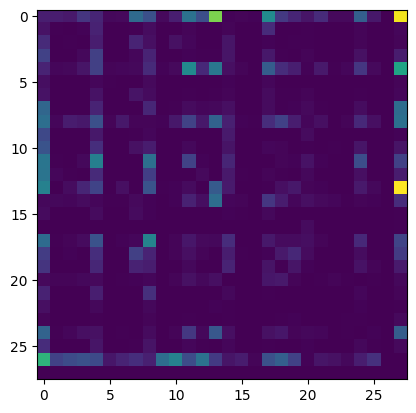

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N)

Define an inverse mapping, so we can visualize the bi-gram alongside its count

In [20]:
itos = {i:s for s,i in stoi.items()}

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

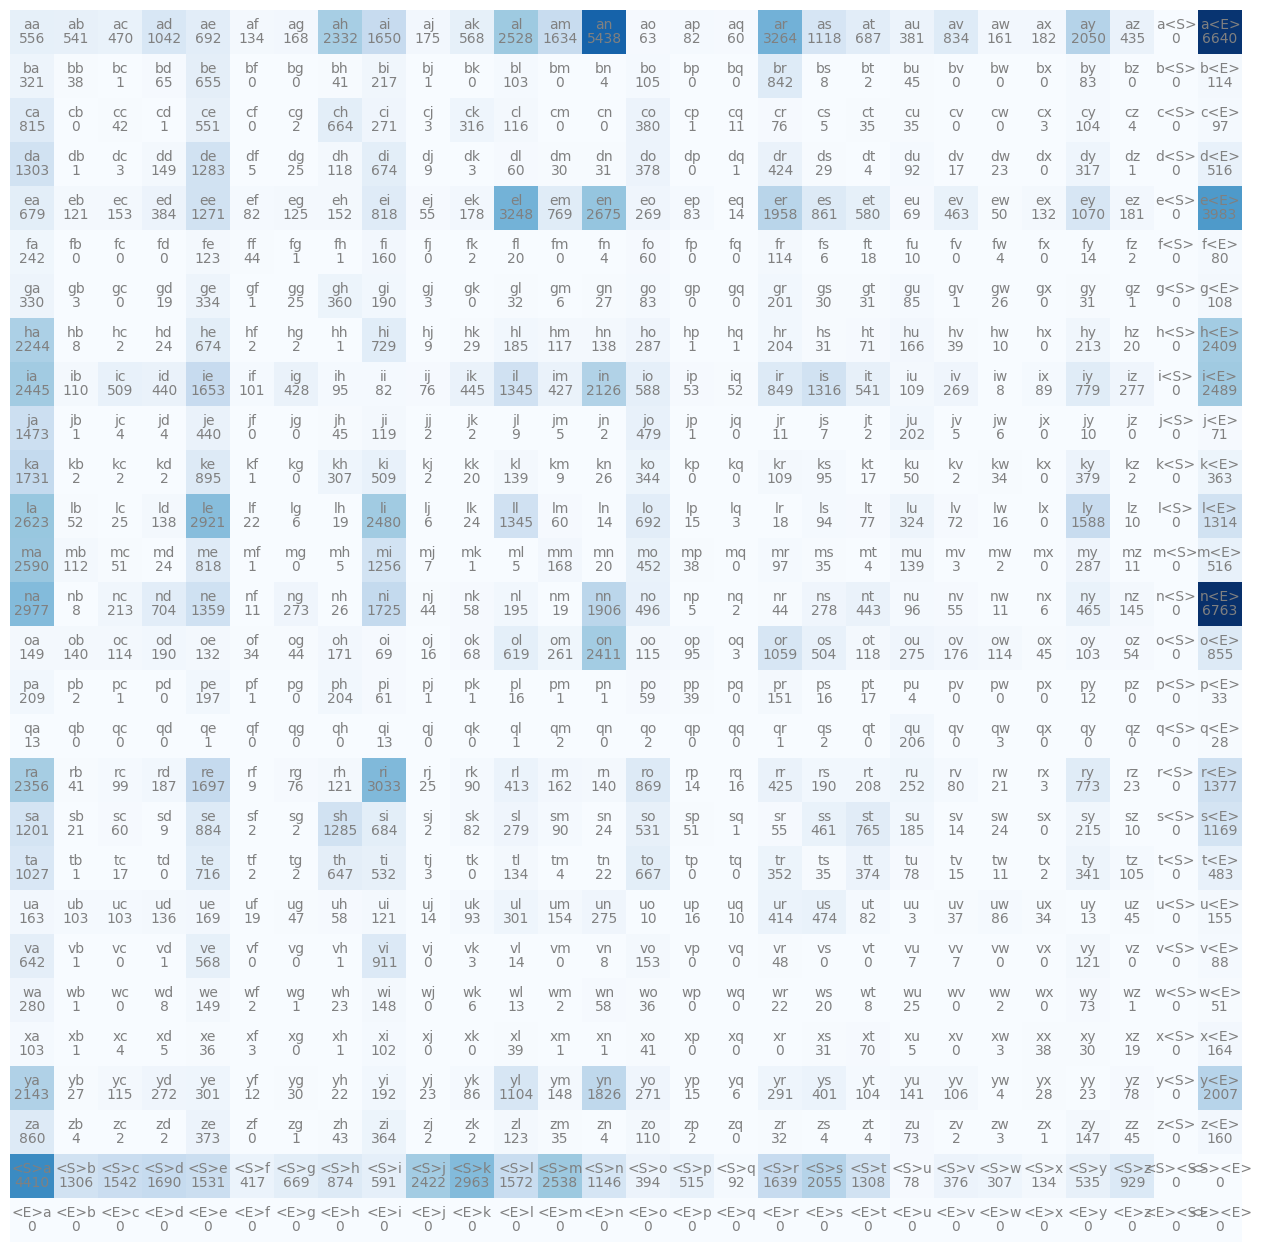

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for i in range(len(itos.items())):
    for j in range(len(itos.items())):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha='center',va='bottom',color='gray')
        plt.text(j,i,N[i,j].item(),ha='center',va='top',color='gray')
plt.axis('off')


Why the `.item()`? We need `.item()` to convert the tensor components from tensors into ints.

In [22]:
N[3,3]

tensor(149, dtype=torch.int32)

In [23]:
N[3,3].item()

149

Switch to using one special characters

In [24]:
chars = sorted(list(set(''.join(words))))
stoi = {s:(i+1) for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [25]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [26]:
N = torch.zeros((28,28), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        i1 = stoi[ch1]
        i2 = stoi[ch2]
        N[i1,i2] += 1 
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0)+1
N

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929,    0],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435,    0],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4,    0],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1,    0],
        [3983,  679,

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

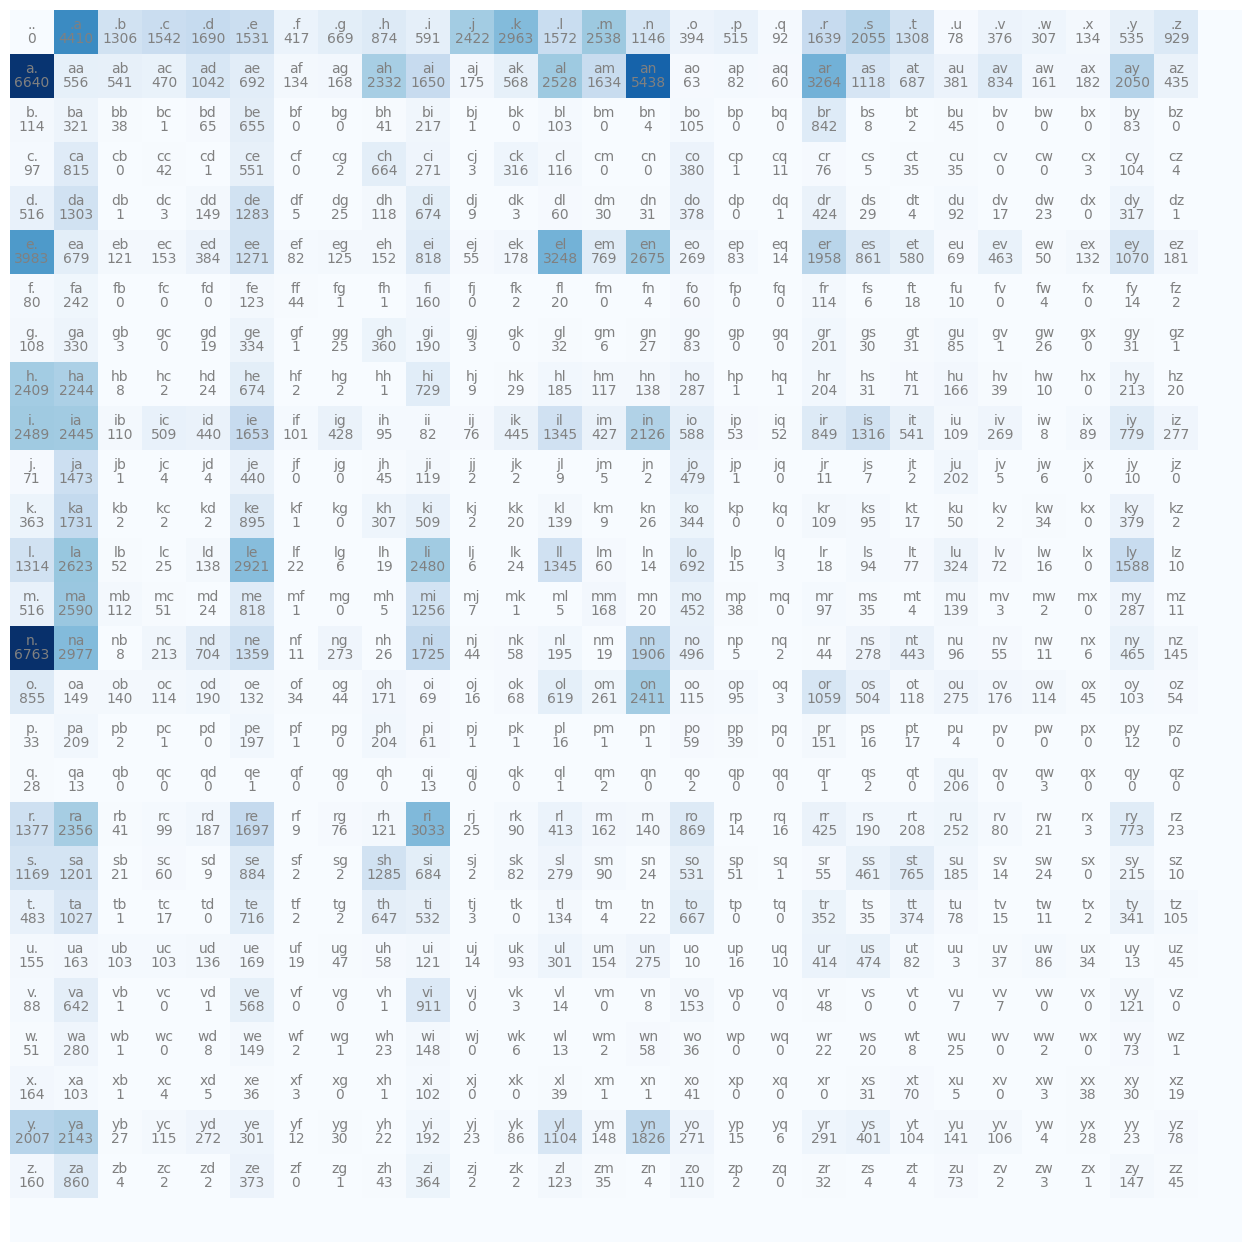

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for i in range(len(itos.items())):
    for j in range(len(itos.items())):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha='center',va='bottom',color='gray')
        plt.text(j,i,N[i,j].item(),ha='center',va='top',color='gray')
plt.axis('off')


We now could sample from the first row to decide how to start a word

In [28]:
N[0,:]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929,    0], dtype=torch.int32)

In [29]:
N[0,:].shape

torch.Size([28])

In [30]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929,    0], dtype=torch.int32)

In [31]:
p = N[0].float()
p

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.,    0.])

Normalize to create a probability distribution for the first char of a word.

In [32]:
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290,
        0.0000])

Here's how we define a random probability distribution as well.

In [33]:
g = torch.Generator().manual_seed(2147483647)
p_fake = torch.rand(3,generator=g)
p_fake = p_fake / p.sum()
p_fake

tensor([0.7081, 0.3542, 0.1054])

Here's how we sample from the probability distribution:

In [34]:
torch.multinomial(p, 
                  num_samples=20,
                  replacement=True,
                  generator=g)


tensor([18, 14, 20,  5,  3, 20, 15, 20, 11, 10, 10, 14, 19, 12,  5, 13, 14,  1,
        11, 18])

These numbers are the indexes of the PMF, which defined the probability used in these 20 samples

In [35]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p,num_samples=1,
                      replacement=True,
                      generator=g).item()
itos[ix]

'j'

sample in a loop

In [37]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    out=[]
    ix = 0
    while True:
        p = N[ix].float()
        p = p / p.sum()
        ix = torch.multinomial(p,
                               num_samples=1,
                          replacement=True,
                          generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

        

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.
dgossmitan.
il.
le.
pann.
that.
janreli.
isa.
dyn.
rijelumemahaunayaleva.
cararr.
jen.
janarta.
maly.
abely.
a.
i.
lavadoni.
themielyawat.
f.
modam.
tavilitikiesaloeverin.
n.
e.
kalbrenelah.
anen.
ch.
k.
jan.
odridrdenanialilpergha.
tezralelia.


Let's try the uniform distribution instead:

In [38]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    out=[]
    ix = 0
    while True:
        #p = N[ix].float()
        #p = p / p.sum()
        p = torch.ones(27) / 27.0
        ix = torch.multinomial(p,
                               num_samples=1,
                          replacement=True,
                          generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

        

juwjdvdipkcqaz.
p.
cfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
coreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
rjpiufmthdt.
rkrrsru.
iyumuyfy.
mjekujcbkhvupwyhvpvhvccragr.
wdkhwfdztta.
mplyisbxlyhuuiqzavmpocbzthqmimvyqwat.
f.
.
ndxjxfpvslqtikyzsaloevgvvnundewkfmbjzqegruxiteaxchwtmurzsodridcdznojvaliypvrghvxtezrwguciqqvywhqelv.
viosvhibdhnceukgmtmwboscnbzoiwupnwnpipixtewbgsgyewfdacbfcxrvjypkmsbranmjrdsydotafvkdkbdepihzpwzsqdab.
vfuolwbasrtugttbiqbujfdtskceqjtcdlcndfujqllsppgkltalmlokdmsl.
fddmxjv.
mfsgxmw.
vdihkvngtojvrdsyqivcob.
uziengogtjvnvqgfjtkqufrxfjlwglykiiluohgnoiuwzylq.
fsgircvmhtipagkxwvjypnsriadmfujnlkcicvatjvryzeljxkbrlrjsp.
puybxzhwuejbiotzqpxrkbhhhgsivfjblaklxoivwqjpdkucftazqgwslvrvqcqmbadayrgufbalqdoumwytowbzqzrvbddvlhqn.
kvhztsmltmpcxnikfn.
inzastwohtcyonakisemrtfxwwlsxihficdlxfkdxjljagkjmeifigffkmcnjylullxfvyyb.
dphbhmwcqseutozswzhksu.
zqnzkadicmoufzbwmpqqfdmtxdxuuvkeikbtviyxvtjxhmlslti